# Executive Summary
- Step 1: Clean up the data, mostly **removing dollar signings and commas separators** for variables such as income.
- Step 2: Use a 5-fold Cross Validation, test the performance of Logistic Regression, Random Forest and Catboost.
The winner turns out to be **Catboost**, with a **validation accuracy of 80.71%** and **AUC of 70.69%**, outperforming the other two.
- Step 3: Generate predictions using the winning model.
- Step 4: Extract some insights from the model using **PDP plots**
  - For example, according to the model, **young and old people** are more likely to be involved in an accident than middle-aged people
  - People with **a higher income and education** are less likely to crash.
  - **Car colors** do not matter at all.
  - People who own **cars with a higher age** are less likely to have an accident, possibly because reckless drivers' cars cannot survive for long.

# 1. Load data and dependencies

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pdpbox import pdp, info_plots

sns.set_style()
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('train_auto.csv', index_col='INDEX')
df_test = pd.read_csv('test_auto.csv', index_col='INDEX')

In [34]:
df.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",Yes,z_F,z_High School,Clerical,5,Private,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",Yes,M,<High School,z_Blue Collar,32,Private,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",Yes,z_F,PhD,Doctor,36,Private,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [35]:
df_test.head()

,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,SEX,EDUCATION,JOB,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
INDEX,,,,,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,0,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,10.0,Highly Urban/ Urban
9,NaN,NaN,1,40.0,1,11.0,"$50,815",Yes,$0,z_No,M,z_High School,Manager,21,Private,"$18,930",6,Minivan,no,"$3,295",1,No,2,1.0,Highly Urban/ Urban
10,NaN,NaN,0,44.0,2,12.0,"$43,486",Yes,$0,z_No,z_F,z_High School,z_Blue Collar,30,Commercial,"$5,900",10,z_SUV,no,$0,0,No,0,10.0,z_Highly Rural/ Rural
18,NaN,NaN,0,35.0,2,NaN,"$21,204",Yes,$0,z_No,M,z_High School,Clerical,74,Private,"$9,230",6,Pickup,no,$0,0,Yes,0,4.0,z_Highly Rural/ Rural
21,NaN,NaN,0,59.0,0,12.0,"$87,460",No,$0,z_No,M,z_High School,Manager,45,Private,"$15,420",1,Minivan,yes,"$44,857",2,No,4,1.0,Highly Urban/ Urban


# 2. EDA and Data Cleaning

In [40]:
# Size of data
print('Size of Data:', df.shape)
print('')

# Null and unique values
summary = pd.DataFrame({'Column Types': df.dtypes,
                        'Number of Nulls': df.isna().sum(),
                        'Unique Values': df.nunique()})
print(summary)


Size of Data: (8161, 25)

            Column Types  Number of Nulls  Unique Values
TARGET_FLAG        int64                0              2
TARGET_AMT       float64                0           1949
KIDSDRIV           int64                0              5
AGE              float64                6             60
HOMEKIDS           int64                0              6
YOJ              float64              454             21
INCOME            object              445           6612
PARENT1           object                0              2
HOME_VAL          object              464           5106
MSTATUS           object                0              2
SEX               object                0              2
EDUCATION         object                0              5
JOB               object              526              8
TRAVTIME           int64                0             97
CAR_USE           object                0              2
BLUEBOOK          object                0           2789
TIF  

In [41]:
def clean_data(df):
    # Convert values such as $1,234 to 1234
    cols = ['INCOME', 'HOME_VAL', 'BLUEBOOK', 'OLDCLAIM']
    for col in cols:
        df[col] = df[col].str.replace('\$|,', '', regex=True).map(float)

    # Convert binary variables into 1/0
    df['PARENT1'] = (df['PARENT1'] == 'Yes') * 1
    df['MSTATUS'] = (df['MSTATUS'] == 'Yes') * 1
    df['SEX_M'] = (df['SEX'] == 'M') * 1
    df['CAR_USER_Commercial'] = (df['CAR_USE'] == 'Commercial') * 1
    df['RED_CAR'] = (df['RED_CAR'] == 'yes') * 1
    df['REVOKED'] = (df['REVOKED'] == 'Yes') * 1
    df['URBANICITY'] = (df['URBANICITY'] == 'Highly Urban/ Urban') * 1
    df = df.drop(['SEX', 'CAR_USE'], axis=1)

    # Fill missing values with -1
    df = df.fillna(-1)

    return df

df = clean_data(df)
df_test = clean_data(df_test)

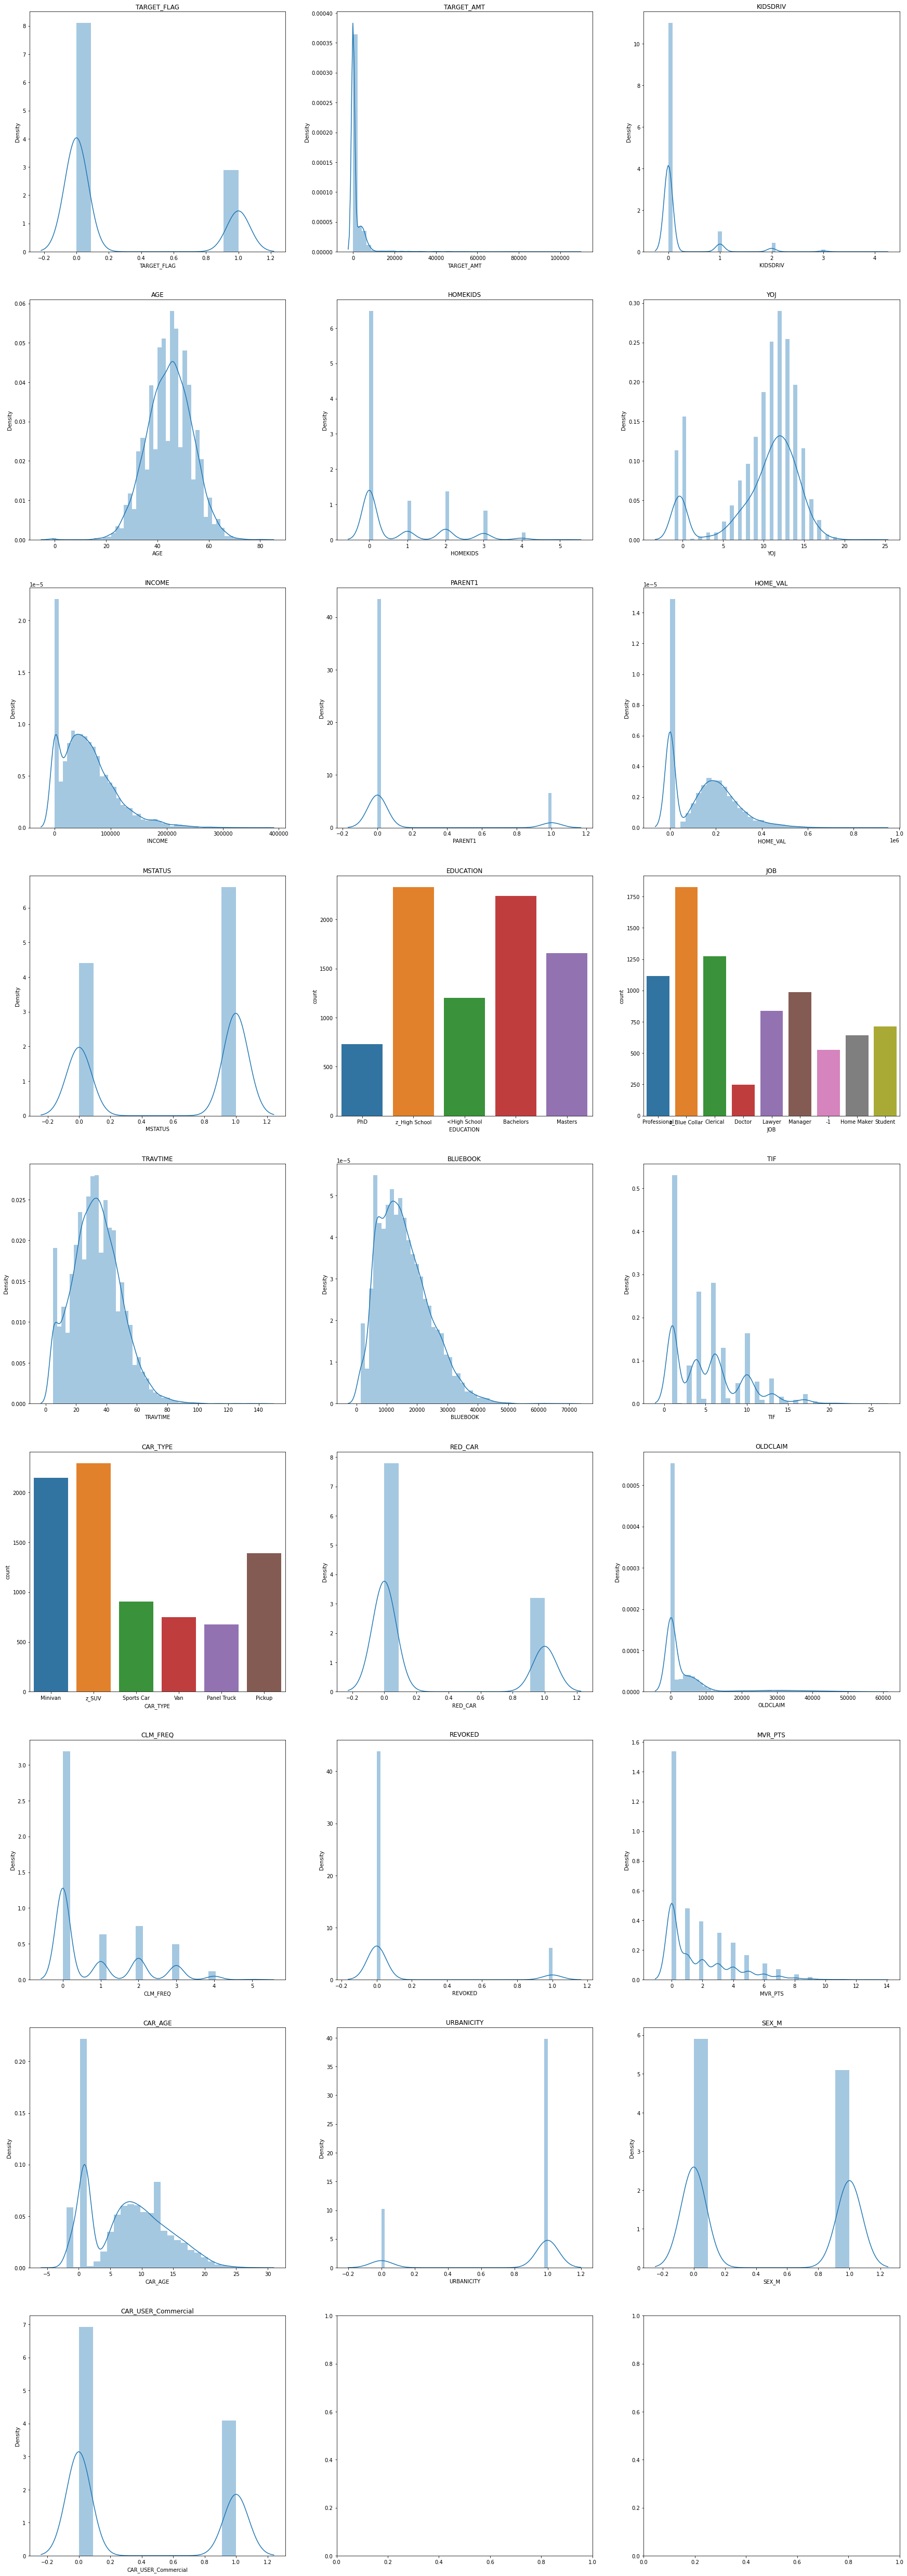

In [42]:
# Plot the distribution of each column
fig, axes = plt.subplots(nrows = 9, ncols = 3)    # axes is 2d array (3x3)
axes = axes.flatten()         # Convert axes to 1d array of length 9
fig.set_size_inches(30, 90)

for ax, col in zip(axes, df.columns):
    if df[col].dtype == 'O':
        sns.countplot(df[col], ax = ax)
    else:
        sns.distplot(df[col], ax = ax)
    ax.set_title(col)

# 3. Predictive Modeling - TARGET_FLAG
## 3.1 Make x, y and x_test

In [43]:
x = df.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1)
x = pd.get_dummies(x)
y = df['TARGET_FLAG']

x_test = df_test.drop(['TARGET_FLAG', 'TARGET_AMT'], axis=1)
x = pd.get_dummies(x)

## 3.2 Test the performance of different models

In [44]:
# A model evaluation helper function
def model_pipeline(model, x, y):
    # Split training and test data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

    # Fit the model
    model.fit(x_train, y_train)

    # Performance metrics
    print(model)
    print()
    print('Dummy Test Accuracy: {:.2%}'.format(accuracy_score(y_test, [0] * len(y_test))))
    print('Training Accuracy: {:.2%}'.format(accuracy_score(y_train, model.predict(x_train))))
    print('Test Accuracy: {:.2%}'.format(accuracy_score(y_test, model.predict(x_test))))

    print('Dummy Test AUC: {:.2%}'.format(roc_auc_score(y_test, [0] * len(y_test))))
    print('Training AUC: {:.2%}'.format(roc_auc_score(y_train, model.predict(x_train))))
    print('Test AUC: {:.2%}'.format(roc_auc_score(y_test, model.predict(x_test))))

    plot_confusion_matrix(model, x_train, y_train)
    plot_confusion_matrix(model, x_test, y_test)

    return model, x_train, x_test, y_train, y_test

LogisticRegression()

Dummy Test Accuracy: 73.18%
Training Accuracy: 73.50%
Test Accuracy: 73.06%
Dummy Test AUC: 50.00%
Training AUC: 51.25%
Test AUC: 51.15%


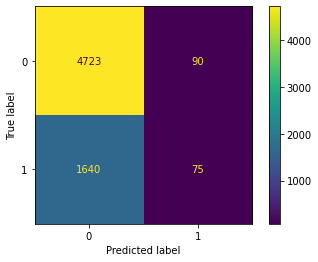

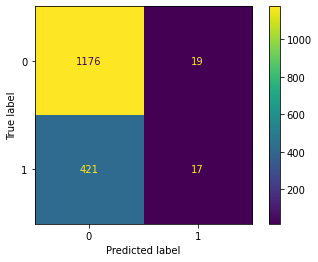

In [45]:
model = LogisticRegression()
model, x_train, x_test, y_train, y_test = model_pipeline(model, x, y)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1)

Dummy Test Accuracy: 73.18%
Training Accuracy: 100.00%
Test Accuracy: 79.55%
Dummy Test AUC: 50.00%
Training AUC: 100.00%
Test AUC: 65.42%


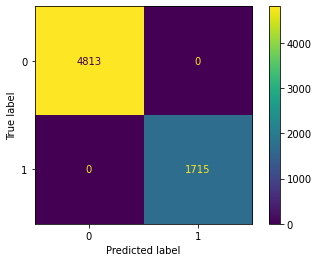

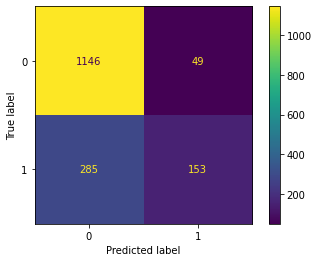

In [46]:
model = RandomForestClassifier(n_estimators=300,
                               class_weight='balanced',
                               n_jobs=-1)
model, x_train, x_test, y_train, y_test = model_pipeline(model, x, y)



Dummy Test Accuracy: 73.18%
Training Accuracy: 90.23%
Test Accuracy: 80.71%
Dummy Test AUC: 50.00%
Training AUC: 83.18%
Test AUC: 70.69%


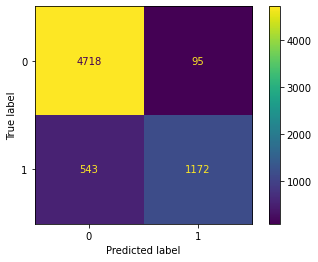

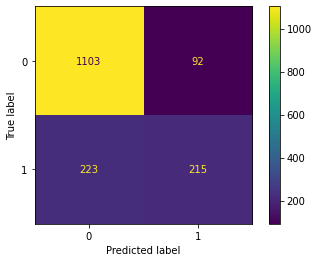

In [47]:
model = CatBoostClassifier(verbose=0)
model, x_train, x_test, y_train, y_test = model_pipeline(model, x, y)

## 3.3 Generate predictions using the best performer - Catboost

In [48]:
model = CatBoostClassifier(verbose=0)
model.fit(x, y)
pred = model.predict(x)
df_pred = pd.DataFrame({'pred': pred})
df_pred.to_csv('predictions.csv', header=False, index=False)

# 4. Insight Extraction

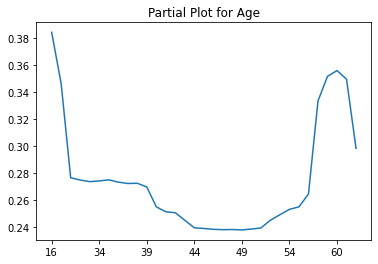

In [58]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x[x['AGE']!=-1],
                          model_features=x.columns,
                          feature='AGE',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='line', title='Partial Plot for Age')
plt.show()

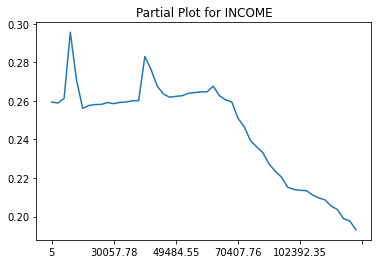

In [59]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x[x['INCOME']>0],
                          model_features=x.columns,
                          feature='INCOME',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='line', title='Partial Plot for INCOME')
plt.show()

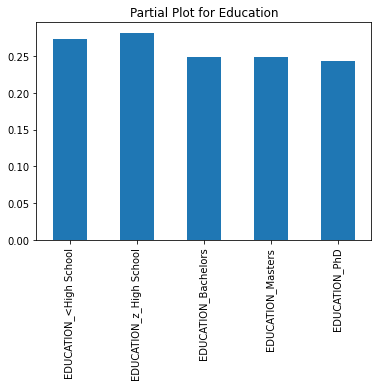

In [60]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x,
                          model_features=x.columns,
                          feature=['EDUCATION_<High School', 'EDUCATION_z_High School', 'EDUCATION_Bachelors', 'EDUCATION_Masters', 'EDUCATION_PhD'],
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='bar', title='Partial Plot for Education')
plt.show()

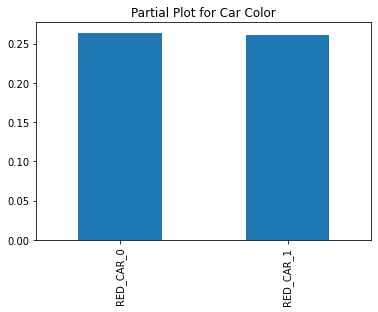

In [61]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x,
                          model_features=x.columns,
                          feature='RED_CAR',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='bar', title='Partial Plot for Car Color')
plt.show()

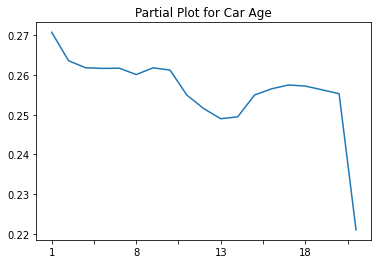

In [62]:
pdp_iso = pdp.pdp_isolate(model=model,
                          dataset=x[x['CAR_AGE']>0],
                          model_features=x.columns,
                          feature='CAR_AGE',
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.plot(kind='line', title='Partial Plot for Car Age')
plt.show()

